# Goal

* How to implement the two most common weights initialization methods
* More about how to access, modify, and explore the weights and biases tensors

# Theory

## Kaiming Initialization (He et al., 2015)

For ReLU networks:

$$
Var(W) = \frac{2}{n_{in}}
$$

### • Uniform
$$
W \sim U(-\sqrt{k}, \sqrt{k}), \quad k = \frac{1}{n_{in}}
$$

### • Normal
$$
W \sim \text{𝒩}\left(0, \sqrt{\frac{2}{n_{in}}}\right)
$$

---

## Xavier Initialization (Glorot & Bengio, 2010)

Designed for **tanh** activations:

### • Uniform
$$
W \sim U\left(-\sqrt{\frac{6}{n_{in} + n_{out}}}, \; \sqrt{\frac{6}{n_{in} + n_{out}}}\right)
$$

### • Normal
$$
W \sim \text{𝒩}\left(0, \sqrt{\frac{2}{n_{in} + n_{out}}}\right)
$$


# Model

In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-2247113016.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [29]:
class CreateNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(100,100)

    self.fc1 = nn.Linear(100, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 100)

    self.output = nn.Linear(100,2)

  def forward(self, x):
    x = F.relu(self.input(x))
    x - F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return self.output(x)

# Comparison

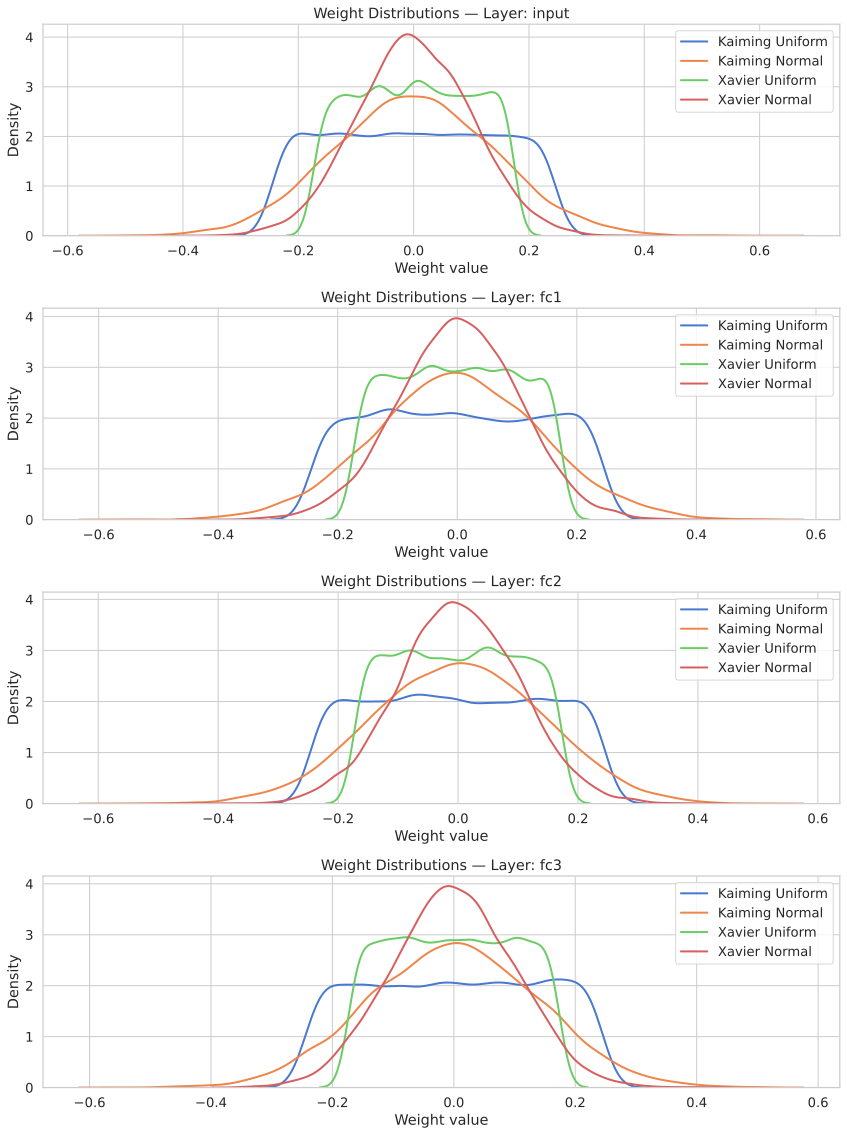

In [57]:
# =========================================================
# Initialization Functions
# =========================================================
def init_weights(net, method):
    for name, param in net.named_parameters():
        if 'weight' in name:
            if method == 'kaiming_uniform':
                nn.init.kaiming_uniform_(param)
            elif method == 'kaiming_normal':
                nn.init.kaiming_normal_(param)
            elif method == 'xavier_uniform':
                nn.init.xavier_uniform_(param)
            elif method == 'xavier_normal':
                nn.init.xavier_normal_(param)
        elif 'bias' in name:
            nn.init.uniform_(param, -0.1, 0.1)
    return net

methods = ['kaiming_uniform', 'kaiming_normal', 'xavier_uniform', 'xavier_normal']

# =========================================================
# Visualization — Distributions per Layer
# =========================================================
def plot_layer_distributions(layers=('input', 'fc1', 'fc2', 'fc3')):
    fig, axes = plt.subplots(len(layers), 1, figsize=(12, 4*len(layers)))
    for i, layer_name in enumerate(layers):
        for m in methods:
            net = CreateNet()
            net = init_weights(net, m)
            w = getattr(net, layer_name).weight.data.numpy().flatten()
            sns.kdeplot(w, ax=axes[i], label=m.replace('_', ' ').title(), lw=2)
        axes[i].set_title(f"Weight Distributions — Layer: {layer_name}")
        axes[i].set_xlabel("Weight value")
        axes[i].set_ylabel("Density")
        axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_layer_distributions(['input', 'fc1', 'fc2', 'fc3'])


[KAIMING_UNIFORM]
Empirical std: 0.14160
Theoretical std: 0.14142
Empirical range: (np.float32(-0.24491431), np.float32(0.24493921))


[KAIMING_NORMAL]
Empirical std: 0.14200
Theoretical std: 0.14142
Empirical range: (np.float32(-0.59593844), np.float32(0.52546877))


[XAVIER_UNIFORM]
Empirical std: 0.10026
Theoretical std: 0.10000
Empirical range: (np.float32(-0.17317964), np.float32(0.17315508))


[XAVIER_NORMAL]
Empirical std: 0.09958
Theoretical std: 0.10000
Empirical range: (np.float32(-0.3890263), np.float32(0.3659858))



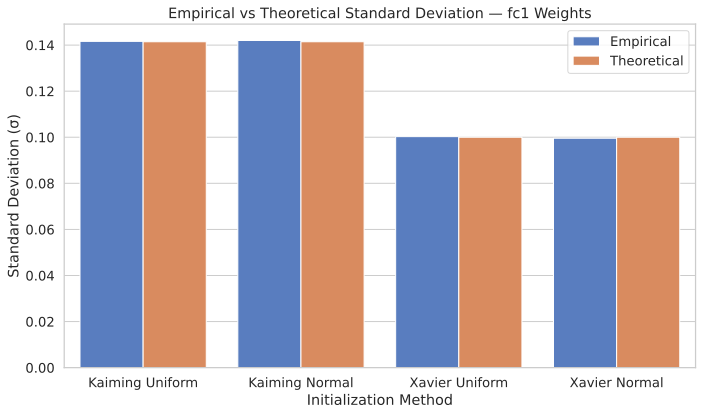

In [59]:
# =========================================================
# Theoretical vs Empirical Test
# =========================================================
def test_initialization(method):
    net = CreateNet()
    net = init_weights(net, method)
    w = net.fc1.weight.data.numpy().flatten()

    empirical_std = np.std(w)
    empirical_range = (np.min(w), np.max(w))
    n_in = net.fc1.in_features
    n_out = net.fc1.out_features

    if 'kaiming' in method:
        theoretical_std = np.sqrt(2 / n_in)
    elif 'xavier' in method:
        theoretical_std = np.sqrt(2 / (n_in + n_out))
    else:
        theoretical_std = None

    print(f"\n[{method.upper()}]")
    print(f"Empirical std: {empirical_std:.5f}")
    print(f"Theoretical std: {theoretical_std:.5f}")
    print(f"Empirical range: {empirical_range}\n")

    return {
        "method": method.replace('_', ' ').title(),
        "empirical_std": empirical_std,
        "theoretical_std": theoretical_std
    }

results = [test_initialization(m) for m in methods]
results = {r["method"]: r for r in results}

# =========================================================
# Visualization of Std Comparison
# =========================================================
df = {
    "Method": [],
    "STD": [],
    "Type": []
}

for m, vals in results.items():
    df["Method"].extend([m, m])
    df["STD"].extend([vals["empirical_std"], vals["theoretical_std"]])
    df["Type"].extend(["Empirical", "Theoretical"])

import pandas as pd
df = pd.DataFrame(df)

plt.figure(figsize=(10,6))
sns.barplot(x="Method", y="STD", hue="Type", data=df)
plt.title("Empirical vs Theoretical Standard Deviation — fc1 Weights")
plt.ylabel("Standard Deviation (σ)")
plt.xlabel("Initialization Method")
plt.legend(title="")
plt.tight_layout()
plt.show()

**Observations:**
- Kaiming methods give slightly higher variance (designed for ReLU)
- Xavier initializations produce smaller ranges, better for tanh/sigmoid
- Empirical distributions align well with theoretical predictions

This confirms that PyTorch’s initialization follows the math accurately.

# Kaiming (Default) Weights Exploration

## Uniform Distribution

### Net

In [30]:
net = CreateNet()
print(net)

CreateNet(
  (input): Linear(in_features=100, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=2, bias=True)
)


### Counts

In [31]:
all_weights = np.array([])
all_biases = np.array([])

for p in net.named_parameters():
  if 'weight' in p[0]:
    all_weights = np.concatenate((all_weights, p[1].data.numpy().flatten()), axis = 0)
  elif 'bias' in p[0]:
    all_biases= np.concatenate((all_biases, p[1].data.numpy().flatten()), axis = 0)

print(f'There are {len(all_biases)} bias parameters.')
print(f'There are {len(all_weights)} weight parameters')

There are 402 bias parameters.
There are 40200 weight parameters


### Hists

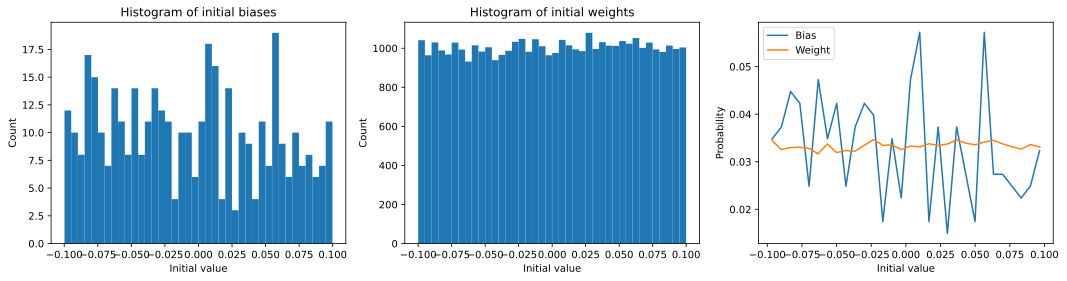

In [32]:
fig, ax = plt.subplots(1,3,figsize = (18,4))

ax[0].hist(all_biases, 40)
ax[0].set_title('Histogram of initial biases')

ax[1].hist(all_weights, 40)
ax[1].set_title('Histogram of initial weights')

# collect histogram data to show as line plots
yb, xb = np.histogram(all_biases, 30)
yw, xw = np.histogram(all_weights, 30)

ax[2].plot((xb[1:] + xb[:-1])/2, yb / np.sum(yb), label = 'Bias')
ax[2].plot((xw[1:]+xw[:-1])/2, yw/np.sum(yw), label = 'Weight')

for i in range(3):
  ax[i].set_xlabel('Initial value')
  ax[i].set_ylabel('Count')
ax[2].set_ylabel('Probability')
ax[2].legend()

plt.show()

### Dists

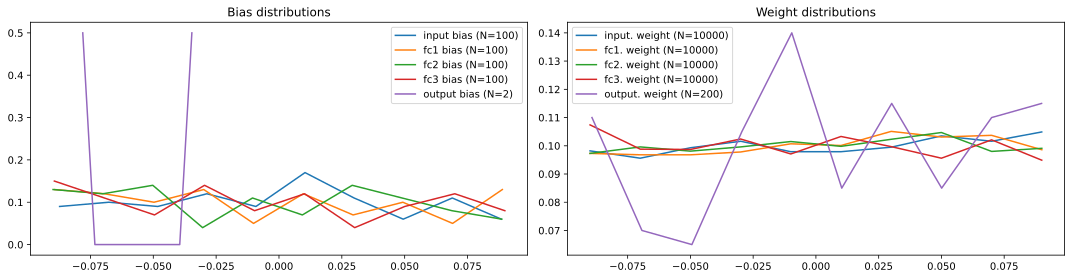

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for p in net.named_parameters():
    these_data = p[1].data.numpy().flatten()
    y, x = np.histogram(these_data, bins=10)
    x_centers = (x[1:] + x[:-1]) / 2

    if 'bias' in p[0]:
        ax[0].plot(x_centers, y / np.sum(y), label=f"{p[0][:-5]} bias (N={len(these_data)})")
    else:
        ax[1].plot(x_centers, y / np.sum(y), label=f"{p[0][:-6]} weight (N={len(these_data)})")

ax[0].set_title("Bias distributions")
ax[1].set_title("Weight distributions")
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()


In [34]:
# What's up with the weird output bias distribution?
print(net.output.bias.data)

tensor([-0.0322, -0.0805])


### Test

With:

`nn.Linear?`

We get:

**Attributes:**

- **weight**: the learnable weights of the module of shape  
  $$ (\text{out_features}, \text{in_features}) $$  
  The values are initialized from  
  $$ U(-\sqrt{k}, \sqrt{k}) $$  
  where  
  $$ k = \frac{1}{\text{in_features}} $$

- **bias**: the learnable bias of the module of shape  
  $$ (\text{out_features}) $$
  If **bias** is `True`, the values are initialized from  
  $$ U(-\sqrt{k}, \sqrt{k}) $$  
  where  
  $$ k = \frac{1}{\text{in_features}} $$


Above formula is Kaiming Random Weights Initialization with Uniform Distribution.


In [35]:
weights_range = [torch.min(net.fc1.weight.data).item(), torch.max(net.fc1.weight.data).item()]
weights_count = len(net.fc1.weight.data)

# theoretical expected value
sigma = np.sqrt(1/weights_count)

# drumm roll
print('Kaiming Uniform Weights k = ' + str(sigma))
print('Empirical range = ' + str(weights_range))

Kaiming Uniform Weights k = 0.1
Empirical range = [-0.09999300539493561, 0.09999221563339233]


In [36]:
# Let's test whether the numbers match our prediction from the formula

bias_range = [torch.min(net.fc1.bias.data).item(), torch.max(net.fc1.bias.data).item()]
bias_count = len(net.fc1.bias.data)

# theoretical expected value
sigma = np.sqrt(1/bias_count)

# drumm roll
print('Kaiming Uniform Bias k = ' + str(sigma))
print('Empirical range = ' + str(bias_range))

Kaiming Uniform Bias k = 0.1
Empirical range = [-0.09920229762792587, 0.09875853359699249]


## Normal Distribution

For Kaiming Normal Distribution we need to go with:

### Net

In [37]:
net = CreateNet()

for p in net.named_parameters():
  if 'weight' in p[0]:
    nn.init.kaiming_normal_(p[1].data)

### Counts

In [38]:
all_weights = np.array([])
all_biases = np.array([])

for p in net.named_parameters():
  if 'weight' in p[0]:
    all_weights = np.concatenate((all_weights, p[1].data.numpy().flatten()), axis = 0)
  elif 'bias' in p[0]:
    all_biases= np.concatenate((all_biases, p[1].data.numpy().flatten()), axis = 0)

print(f'There are {len(all_biases)} bias parameters.')
print(f'There are {len(all_weights)} weight parameters')

There are 402 bias parameters.
There are 40200 weight parameters


### Hists

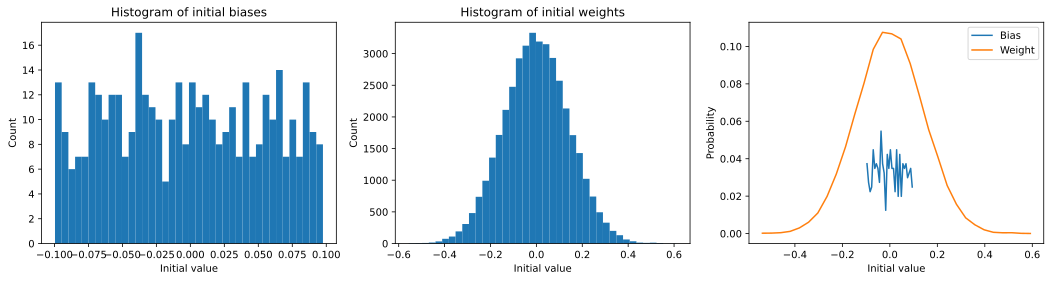

In [39]:
fig, ax = plt.subplots(1,3,figsize = (18,4))

ax[0].hist(all_biases, 40)
ax[0].set_title('Histogram of initial biases')

ax[1].hist(all_weights, 40)
ax[1].set_title('Histogram of initial weights')

# collect histogram data to show as line plots
yb, xb = np.histogram(all_biases, 30)
yw, xw = np.histogram(all_weights, 30)

ax[2].plot((xb[1:] + xb[:-1])/2, yb / np.sum(yb), label = 'Bias')
ax[2].plot((xw[1:]+xw[:-1])/2, yw/np.sum(yw), label = 'Weight')

for i in range(3):
  ax[i].set_xlabel('Initial value')
  ax[i].set_ylabel('Count')
ax[2].set_ylabel('Probability')
ax[2].legend()

plt.show()

### Dists

Let's check how layers distributions have changed

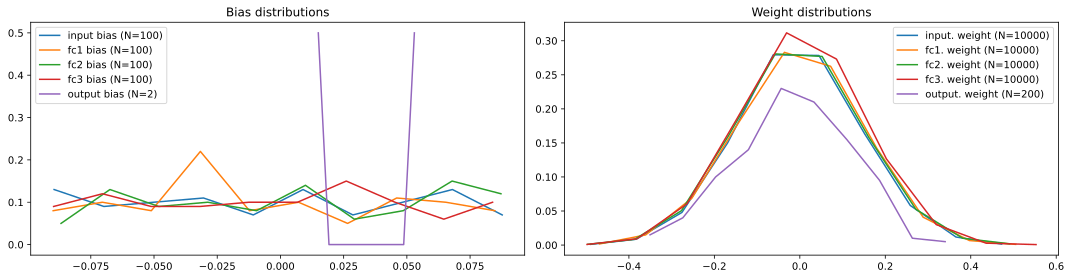

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for p in net.named_parameters():
    these_data = p[1].data.numpy().flatten()
    y, x = np.histogram(these_data, bins=10)
    x_centers = (x[1:] + x[:-1]) / 2

    if 'bias' in p[0]:
        ax[0].plot(x_centers, y / np.sum(y), label=f"{p[0][:-5]} bias (N={len(these_data)})")
    else:
        ax[1].plot(x_centers, y / np.sum(y), label=f"{p[0][:-6]} weight (N={len(these_data)})")

ax[0].set_title("Bias distributions")
ax[1].set_title("Weight distributions")
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

### Test

In [41]:
weights_range = [torch.min(net.fc1.weight.data).item(), torch.max(net.fc1.weight.data).item()]
weights_count = len(net.fc1.weight.data)

# theoretical expected value
sigma = np.sqrt(1/weights_count)

# drumm roll
print('Kaiming Normal Weights k = ' + str(sigma))
print('Empirical range = ' + str(weights_range))

Kaiming Normal Weights k = 0.1
Empirical range = [-0.523120105266571, 0.5591487288475037]


In [42]:
# Let's test whether the numbers match our prediction from the formula

bias_range = [torch.min(net.fc1.bias.data).item(), torch.max(net.fc1.bias.data).item()]
bias_count = len(net.fc1.bias.data)

# theoretical expected value
sigma = np.sqrt(1/bias_count)

# drumm roll
print('Kaiming Normal Bias k = ' + str(sigma))
print('Empirical range = ' + str(bias_range))

Kaiming Normal Bias k = 0.1
Empirical range = [-0.09958763420581818, 0.09449069947004318]


# Xavier Weights Initialization

## Uniform Distribution

### Net

In [43]:
net = CreateNet()

for p in net.named_parameters():
  if 'weight' in p[0]:
    nn.init.xavier_uniform_(p[1].data)

### Counts

In [44]:
all_weights = np.array([])
all_biases = np.array([])

for p in net.named_parameters():
  if 'weight' in p[0]:
    all_weights = np.concatenate((all_weights, p[1].data.numpy().flatten()), axis = 0)
  elif 'bias' in p[0]:
    all_biases= np.concatenate((all_biases, p[1].data.numpy().flatten()), axis = 0)

print(f'There are {len(all_biases)} bias parameters.')
print(f'There are {len(all_weights)} weight parameters')

There are 402 bias parameters.
There are 40200 weight parameters


### Hists

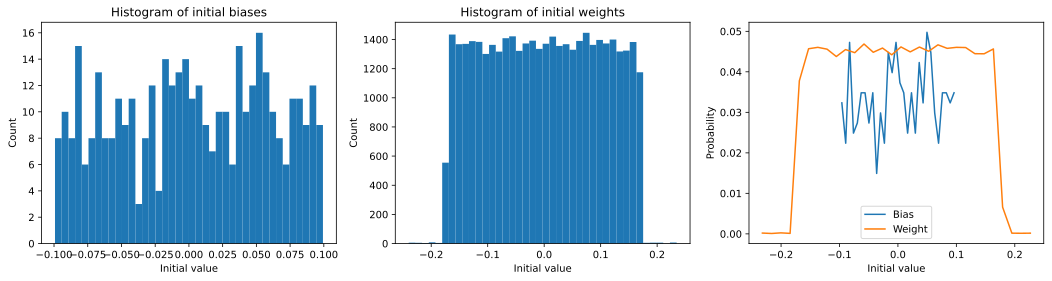

In [45]:
fig, ax = plt.subplots(1,3,figsize = (18,4))

ax[0].hist(all_biases, 40)
ax[0].set_title('Histogram of initial biases')

ax[1].hist(all_weights, 40)
ax[1].set_title('Histogram of initial weights')

# collect histogram data to show as line plots
yb, xb = np.histogram(all_biases, 30)
yw, xw = np.histogram(all_weights, 30)

ax[2].plot((xb[1:] + xb[:-1])/2, yb / np.sum(yb), label = 'Bias')
ax[2].plot((xw[1:]+xw[:-1])/2, yw/np.sum(yw), label = 'Weight')

for i in range(3):
  ax[i].set_xlabel('Initial value')
  ax[i].set_ylabel('Count')
ax[2].set_ylabel('Probability')
ax[2].legend()

plt.show()

### Dists

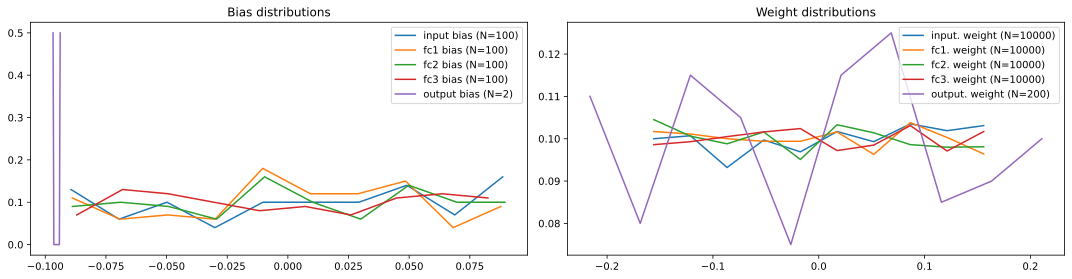

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for p in net.named_parameters():
    these_data = p[1].data.numpy().flatten()
    y, x = np.histogram(these_data, bins=10)
    x_centers = (x[1:] + x[:-1]) / 2

    if 'bias' in p[0]:
        ax[0].plot(x_centers, y / np.sum(y), label=f"{p[0][:-5]} bias (N={len(these_data)})")
    else:
        ax[1].plot(x_centers, y / np.sum(y), label=f"{p[0][:-6]} weight (N={len(these_data)})")

ax[0].set_title("Bias distributions")
ax[1].set_title("Weight distributions")
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

### Test

In [47]:
weights_range = [torch.min(net.fc1.weight.data).item(), torch.max(net.fc1.weight.data).item()]
weights_count = len(net.fc1.weight.data)

# theoretical expected value
sigma = np.sqrt(1/weights_count)

# drumm roll
print('Xavier Uniform Weights k = ' + str(sigma))
print('Empirical range = ' + str(weights_range))

Xavier Uniform Weights k = 0.1
Empirical range = [-0.17320206761360168, 0.1731993854045868]


In [48]:
# Let's test whether the numbers match our prediction from the formula

bias_range = [torch.min(net.fc1.bias.data).item(), torch.max(net.fc1.bias.data).item()]
bias_count = len(net.fc1.bias.data)

# theoretical expected value
sigma = np.sqrt(1/bias_count)

# drumm roll
print('Bias k = ' + str(sigma))
print('Empirical range = ' + str(bias_range))

Bias k = 0.1
Empirical range = [-0.09864562749862671, 0.09756790846586227]


## Normal Distribution

### Net

In [49]:
net = CreateNet()

for p in net.named_parameters():
  if 'weight' in p[0]:
    nn.init.xavier_normal_(p[1].data)

### Counts

In [50]:
all_weights = np.array([])
all_biases = np.array([])

for p in net.named_parameters():
  if 'weight' in p[0]:
    all_weights = np.concatenate((all_weights, p[1].data.numpy().flatten()), axis = 0)
  elif 'bias' in p[0]:
    all_biases= np.concatenate((all_biases, p[1].data.numpy().flatten()), axis = 0)

print(f'There are {len(all_biases)} bias parameters.')
print(f'There are {len(all_weights)} weight parameters')

There are 402 bias parameters.
There are 40200 weight parameters


### Hists

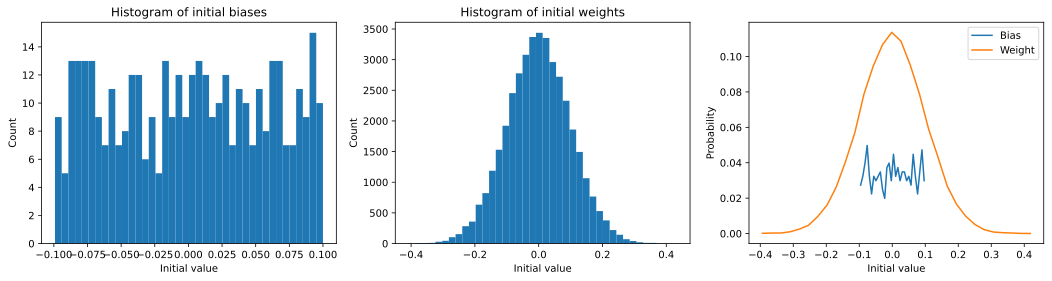

In [51]:
fig, ax = plt.subplots(1,3,figsize = (18,4))

ax[0].hist(all_biases, 40)
ax[0].set_title('Histogram of initial biases')

ax[1].hist(all_weights, 40)
ax[1].set_title('Histogram of initial weights')

# collect histogram data to show as line plots
yb, xb = np.histogram(all_biases, 30)
yw, xw = np.histogram(all_weights, 30)

ax[2].plot((xb[1:] + xb[:-1])/2, yb / np.sum(yb), label = 'Bias')
ax[2].plot((xw[1:]+xw[:-1])/2, yw/np.sum(yw), label = 'Weight')

for i in range(3):
  ax[i].set_xlabel('Initial value')
  ax[i].set_ylabel('Count')
ax[2].set_ylabel('Probability')
ax[2].legend()

plt.show()

### Dists

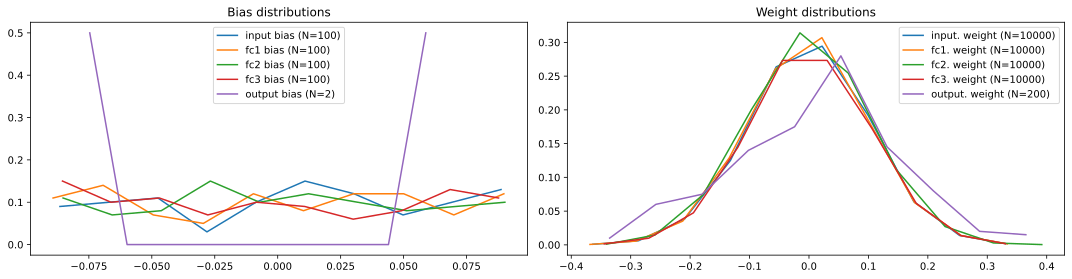

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for p in net.named_parameters():
    these_data = p[1].data.numpy().flatten()
    y, x = np.histogram(these_data, bins=10)
    x_centers = (x[1:] + x[:-1]) / 2

    if 'bias' in p[0]:
        ax[0].plot(x_centers, y / np.sum(y), label=f"{p[0][:-5]} bias (N={len(these_data)})")
    else:
        ax[1].plot(x_centers, y / np.sum(y), label=f"{p[0][:-6]} weight (N={len(these_data)})")

ax[0].set_title("Bias distributions")
ax[1].set_title("Weight distributions")
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

### Test

In [53]:
weights_range = [torch.min(net.fc1.weight.data).item(), torch.max(net.fc1.weight.data).item()]
weights_count = len(net.fc1.weight.data)

# theoretical expected value
sigma = np.sqrt(1/weights_count)

# drumm roll
print('Xavier Normal Weights k = ' + str(sigma))
print('Empirical range = ' + str(weights_range))

Xavier Normal Weights k = 0.1
Empirical range = [-0.4075445234775543, 0.3729465901851654]


In [54]:
# Let's test whether the numbers match our prediction from the formula

bias_range = [torch.min(net.fc1.bias.data).item(), torch.max(net.fc1.bias.data).item()]
bias_count = len(net.fc1.bias.data)

# theoretical expected value
sigma = np.sqrt(1/bias_count)

# drumm roll
print('Xavier Normal Bias k = ' + str(sigma))
print('Empirical range = ' + str(bias_range))

Xavier Normal Bias k = 0.1
Empirical range = [-0.09916489571332932, 0.09977351874113083]
